In [1]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import shutil
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xa
import rioxarray as rxa
from rioxarray.merge import merge_arrays, merge_datasets

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

image_fps = [f for f in image_fps if f['fp'].endswith('.unw.grd.tiff')]

with open(expanduser('/bsuhome/zacharykeskinen/uavsar/results/coh_amp_inc/resv1'), 'rb') as f:
    res = pickle.load(f)
sub = res.loc[::1000,:]
sub['inc'] = np.rad2deg(sub.inc.values)
sub['dt'] = sub.flight2 - sub.flight1
# res.loc[:,'inc'] = np.rad2deg(res.inc)

/tmp/ipykernel_27325/680034380.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['inc'] = np.rad2deg(sub.inc.values)
/tmp/ipykernel_27325/680034380.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['dt'] = sub.flight2 - sub.flight1


array([[<AxesSubplot:title={'center':'inc'}>,
        <AxesSubplot:title={'center':'phase'}>],
       [<AxesSubplot:title={'center':'cor'}>, <AxesSubplot:>]],
      dtype=object)

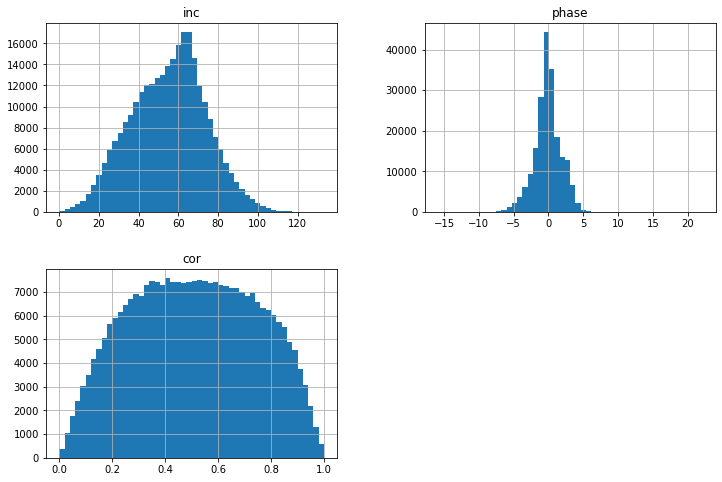

In [2]:
sub[['inc','phase','cor']].hist(bins = 50, figsize = (12,8))

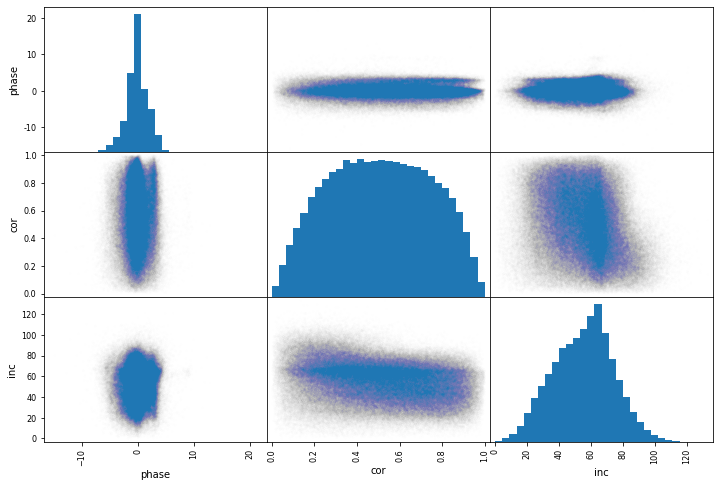

In [3]:
from pandas.plotting import scatter_matrix
scatter_matrix(sub, figsize = (12,8), diagonal = 'hist', alpha = 0.005, hist_kwds = {'bins':30})
plt.show()

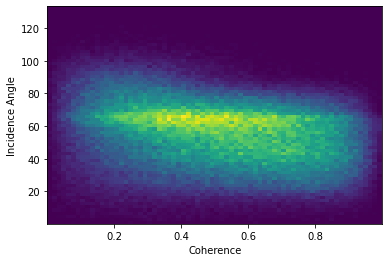

In [4]:
x = sub['cor'][~np.isnan(sub['cor']) & ~np.isnan(sub['inc'])].values
y = sub['inc'][~np.isnan(sub['cor']) & ~np.isnan(sub['inc'])].values
heatmap, xedges, yedges = np.histogram2d(x, y, bins=70)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect = 'auto')
plt.xlabel('Coherence')
plt.ylabel('Incidence Angle')
plt.show()

In [5]:
from sklearn.linear_model import LinearRegression
sk = sub[(sub.dt < pd.Timedelta('9 days')) & (sub.pol == 'VV') & (sub.inc > 60)]
X = sk['inc'][~np.isnan(sk['cor']) & ~np.isnan(sk['inc'])].values.reshape(-1,1)
y = sk['cor'][~np.isnan(sk['cor']) & ~np.isnan(sk['inc'])].values

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)

0.13061512269896158
[-0.00857068]
1.1147423


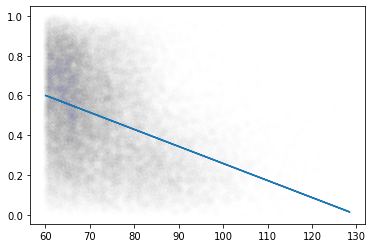

In [6]:
plt.scatter(X, y, alpha = 0.002)
plt.plot(X, reg.coef_* X + reg.intercept_)